<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Introduction to Neural Networks</center></font></h1>
<h1><center>Bank Churn Prediction</center></h1>
<h3><center>Charlcye Mitchell, February 2023</center></h3>

#Problem Statement + EDA

##Context
Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.


##Objective
Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

##Data Dictionary

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

*   **CustomerId:** Unique ID which is assigned to each customer
*   **Surname:** Last name of the customer 
*   **CreditScore:** It defines the credit history of the customer.  
*   **Geography:** A customer’s location    
*   **Gender:** It defines the Gender of the customer   
*   **Age:** Age of the customer     
*   **Tenure:** Number of years for which the customer has been with the bank
*   **NumOfProducts:** It refers to the number of products that a customer has purchased through the bank.
*   **Balance:** Account balance
*   **HasCrCard:** It is a categorical variable that decides whether the customer has a credit card or not.
*   **EstimatedSalary:** Estimated salary 
*   **isActiveMember:** It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
*   **Exited:** It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values: 
                    0=No ( Customer did not leave the bank )

                    1=Yes ( Customer left the bank )


## Read the Dataset

###Importing the necessary packages

In [ ]:
!pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/ydataai/pandas-profiling/archive/master.zip
  Preparing metadata (setup.py) ... done


In [ ]:
# Basic libraries for reading and manipulating data
import numpy as np
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

# Libraries for model training
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer


# Libraries for DNN
import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")



###Reading the Datasets

The initial steps to get an overview of any dataset is to: 
- observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- get information about the number of rows and columns in the dataset
- find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
- check the statistical summary of the dataset to get an overview of the numerical columns of the data

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read in the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Churn.csv')

#Exploratory Data Analysis


## Print the overview of the data (statistical summary, shape, info, etc)

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df)

In [ ]:
profile.to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

## Eliminate the unique features from the dataset with proper reasoning

In [ ]:
# We can drop row number, customer ID, and surname as they willnot have any meaningful correlation to whether or not a customer will churn in the next 6 months.
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


## Univariate analysis

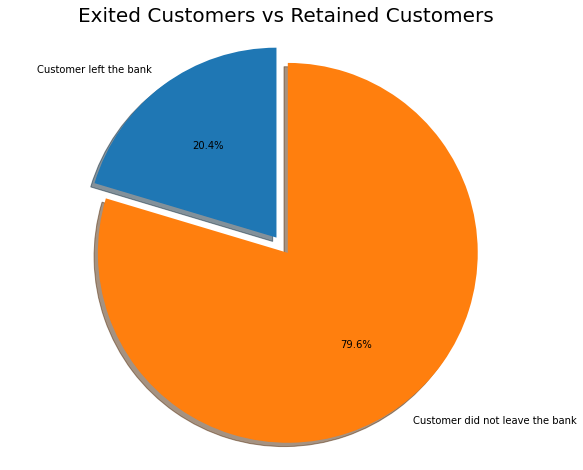

In [ ]:
labels = 'Customer left the bank', 'Customer did not leave the bank'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Exited Customers vs Retained Customers", size = 20)
plt.show()

*   'Exited' is the Target Feature.

*   About 1/5 customers churn. Because our goal is to retain the churning customers, we will err on the side of detecting as many of these customers as possible rather than worrying about misidentifing customers who would not have churned as at-risk.

*   There is no significant linear relationship between the features.


## Bivariate analysis

1.   Avg Credit Score is almost the same for Active and Churned customers.
2.   Young people have higher retention than older people.
3.   The Average Bank Balance is high for churned customers.
4.   Churn is high for German customers.
5.   Churn is high among the non-active members.

# Data Pre-processing

## Split the target variable and predictors

In [ ]:
X = df.drop(['Exited'],axis=1) 
y = df[['Exited']]

In [ ]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [ ]:
y.head()

,Exited
0,1
1,0
2,1
3,0
4,0


## Split the data into train and test

In [ ]:
X_large, X_test, y_large, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42,stratify=y,shuffle = True)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_large,y_large, test_size = 0.2, random_state = 42,stratify=y_large, shuffle = True)

## Categorical Encoding

In [ ]:
X_train = pd.get_dummies(X_train, columns=["Geography","Gender"],drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Geography","Gender"],drop_first=True)
X_val = pd.get_dummies(X_val, columns=["Geography","Gender"],drop_first=True)

## Normalize the data

In [ ]:
sc=StandardScaler()
temp = sc.fit(X_train[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]])
X_train[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]] = temp.transform(X_train[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]])
X_test[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]] = temp.transform(X_test[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]])
X_val[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]] = temp.transform(X_val[["CreditScore","Age","Tenure","Balance","EstimatedSalary"]])

# Model building

## Build the Neural Network model

In [ ]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing the ANN
classifier = Sequential()
# Adding the input layer with 64 neurons with relu as activation function with input of 11 variables
classifier.add(Dense(activation = 'relu', input_dim = 11, units=64))
#Adding 1st hidden layer with 32 neurons
classifier.add(Dense(32, activation='relu'))
# Adding the output layer 
# we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
# We use the sigmoid because we want probability outcomes
classifier.add(Dense(1, activation = 'sigmoid')) 

In [ ]:
# Compile the model with SGD optimizer and binary cross entropy as loss with accuracy as metrics
classifier.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Model summary
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting the model 
history=classifier.fit(X_train, y_train,           
          validation_data=(X_val,y_val),
          epochs=100,
          batch_size=32)

Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5214 - accuracy: 0.7875 - val_loss: 0.4830 - val_accuracy: 0.7962
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4739 - accuracy: 0.7964 - val_loss: 0.4583 - val_accuracy: 0.7969
Epoch 3/100
200/200 [==============================] - 1s 2ms/step - loss: 0.4546 - accuracy: 0.7969 - val_loss: 0.4439 - val_accuracy: 0.8019
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4424 - accuracy: 0.8005 - val_loss: 0.4357 - val_accuracy: 0.8075
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4346 - accuracy: 0.8034 - val_loss: 0.4306 - val_accuracy: 0.8112
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.8080 - val_loss: 0.4276 - val_accuracy: 0.8150
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4257 - accuracy: 0.8112 - val_loss: 0.4254 - val_accuracy: 0.8144

63/63 [==============================] - 0s 2ms/step - loss: 0.3465 - accuracy: 0.8570


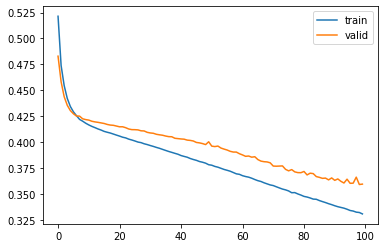

In [ ]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#Printing results
results = classifier.evaluate(X_test, y_test)

##Model Performance Evaluation

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

63/63 [==============================] - 0s 1ms/step


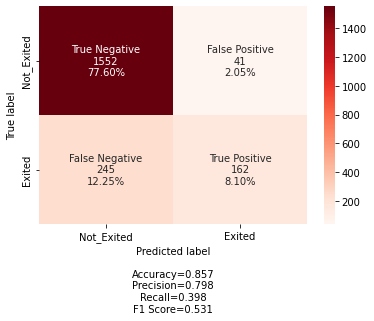

In [ ]:
#Calculating the confusion matrix 
y_pred1=classifier.predict(X_test)

#Let's predict using default threshold
y_pred1 = (y_pred1 > 0.5)
cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

This model has good accuracy and precision but the recall is poor, likely due to the imbalanced dataset.

## Find the optimal threshold using ROC-AUC Curves

200/200 [==============================] - 0s 2ms/step
Best Threshold=0.167119, G-Mean=0.802


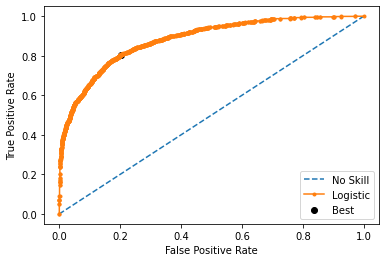

In [ ]:
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat = model_e.predict(X_train)
# keep probabilities for the positive outcome only
yhat = yhat[:, 0]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
#Predicting the results using best as a threshold
y_pred_e=model_e.predict(X_test)
y_pred_e = (y_pred_e > thresholds[ix])
y_pred_e

63/63 [==============================] - 0s 1ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

In [ ]:
#Accuracy as per the classification report 
cr=metrics.classification_report(y_test,y_pred_e)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1593
           1       0.46      0.77      0.57       407

    accuracy                           0.77      2000
   macro avg       0.69      0.77      0.71      2000
weighted avg       0.83      0.77      0.79      2000



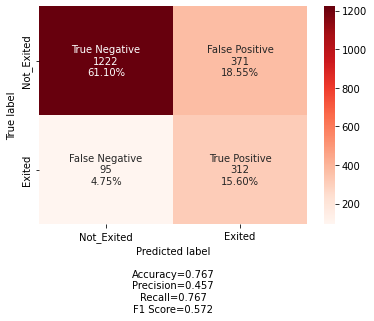

In [ ]:
#Calculating the confusion matrix 

cm1=confusion_matrix(y_test, y_pred_e)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

Recall on this model is improved, but accuracy declined.

## Can performance be improved? Check and comment

In [ ]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
import random
random.seed(2)
tf.random.set_seed(2)

In [ ]:
#Initializing the neural network
improved_model = Sequential()
#Adding the input layer with 32 neurons and relu as activation function
improved_model.add(Dense(32,activation='relu',input_dim = X_train.shape[1]))
# Adding dropout with ratio of 0.2
improved_model.add(Dropout(0.2))
# Adding the first hidden layer with 16 neurons with relu as activation functions
improved_model.add(Dense(16,activation='relu'))
# Adding dropout with ratio of 0.1
improved_model.add(Dropout(0.1))
# Adding the second hidden layer with 8 neurons with relu as activation functions
improved_model.add(Dense(8,activation='relu'))
# Adding the output layer
improved_model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
# Summary of the model
improved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                384       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,057
Trainable params: 1,057
Non-trainabl

In [ ]:
#Compiling the ANN with Adam optimizer 
optimizer = tf.keras.optimizers.Adam(0.001)
# Complining the model with binary cross entropy as loss function and accuracy as metrics
improved_model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

## Build another model to implement these improvements

In [ ]:
#Fitting the ANN with batch_size = 32 and 100 epochs 
history_3 = improved_model.fit(X_train,y_train,batch_size=32,epochs=100,verbose=1,validation_data=(X_val,y_val),callbacks=[es_cb])

Epoch 1/100
200/200 [==============================] - 2s 6ms/step - loss: 0.5123 - accuracy: 0.7588 - val_loss: 0.4538 - val_accuracy: 0.7962
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4515 - accuracy: 0.7967 - val_loss: 0.4376 - val_accuracy: 0.7981
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 0.4369 - accuracy: 0.8025 - val_loss: 0.4335 - val_accuracy: 0.8031
Epoch 4/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4310 - accuracy: 0.8073 - val_loss: 0.4329 - val_accuracy: 0.8087
Epoch 5/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4323 - accuracy: 0.8066 - val_loss: 0.4276 - val_accuracy: 0.8131
Epoch 6/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4300 - accuracy: 0.8119 - val_loss: 0.4229 - val_accuracy: 0.8200
Epoch 7/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4240 - accuracy: 0.8197 - val_loss: 0.4189 - val_accuracy: 0.8200

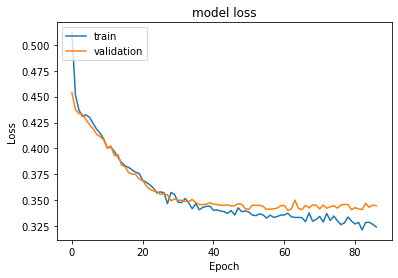

In [ ]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

From the above plot, we can observe that the train and validation curves are having smooth lines. Reducing the number of neurons and adding dropouts to the model worked, and the problem of overfitting was solved.

200/200 [==============================] - 0s 1ms/step
Best Threshold=0.225077, G-Mean=0.808


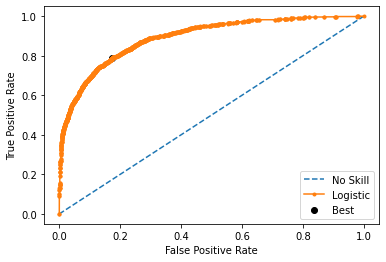

In [ ]:
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat = improved_model.predict(X_train)
# keep probabilities for the positive outcome only
yhat = yhat[:, 0]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
#Predicting the results using best as a threshold
y_pred_e=improved_model.predict(X_test)
y_pred_3 = (y_pred_e > thresholds[ix])
y_pred_3

63/63 [==============================] - 0s 1ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

In [ ]:
#Accuracy as per the classification report 
cr=metrics.classification_report(y_test,y_pred_3)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.81      0.86      1593
           1       0.50      0.74      0.60       407

    accuracy                           0.79      2000
   macro avg       0.71      0.78      0.73      2000
weighted avg       0.84      0.79      0.81      2000



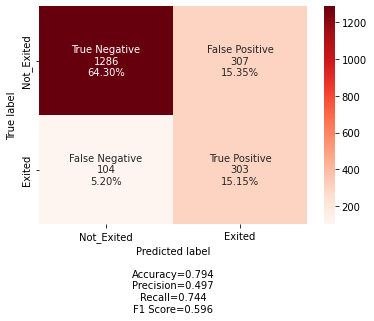

In [ ]:
#Calculating the confusion matrix 

cm1=confusion_matrix(y_test, y_pred_3)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

# Actionable Insights & Recommendations
Conclude with the key takeaways for the business

*   As older customers, females, and high balance customers are churning more than younger customers, the bank may want to evaluate and address the needs of these specific demographics.

*   There is a high proportion of inactive members, and inactive accounts are likely to churn. The bank may want to specifically target these customers with engagement campaigns.